# Building Frederike's second force field

In [3]:
import matplotlib.pyplot as plt

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=False

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


for i in {1..19}; do (mkdir "outcar${i}"; mv "outcar${i}.txt" "outcar${i}/OUTCAR"); done
for i in {1..19}; do (echo "outcar/outcar${i}" >> data_list.txt); done
for f in $(ls OUTCARS/); do echo "OUTCARS/$f" >> data_list.txt; done

In [4]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="DFT.db",file_list="data_list.txt",overwrite=True, greedy=False)

    Building data-bases: 100%|██████████████████████████████████████████████████████████| 31/31 [00:27<00:00,  1.14it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [5]:
!ase db DFT.db

id| age|formula      |calculator|  energy|natoms| fmax|pbc| volume|charge|    mass| smax|magmom
 1|254s|LiNiO2       |vasp      | -23.773|     4|0.018|TTT| 32.947| 0.000|  97.631|0.003| 1.003
 2|253s|Li2Ni3O6     |vasp      | -66.600|    11|0.010|TTT| 98.426| 0.000| 285.954|0.001| 2.000
 3|252s|Li2Ni3O6     |vasp      | -66.515|    11|0.009|TTT| 98.716| 0.000| 285.954|0.001| 1.999
 4|251s|Li2Ni4O8     |vasp      | -84.849|    14|0.011|TTT|127.955| 0.000| 376.646|0.000| 1.999
 5|250s|Li2Ni4O8     |vasp      | -85.453|    14|0.015|TTT|132.113| 0.000| 376.646|0.001| 1.935
 6|249s|Li2Ni4O8     |vasp      | -85.453|    14|0.015|TTT|132.113| 0.000| 376.646|0.001| 1.935
 7|248s|LiNi3O6      |vasp      | -61.594|    10|0.017|TTT| 98.987| 0.000| 279.014|0.001| 0.998
 8|247s|LiNi3O6      |vasp      | -61.447|    10|0.012|TTT| 96.742| 0.000| 279.014|0.001| 0.722
 9|246s|LiNi4O8      |vasp      | -80.114|    13|0.016|TTT|126.516| 0.000| 369.706|0.001|-0.340
10|245s|LiNi4O8      |vasp      | -80.32

In [6]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=Fit_on_forces)

    Fetching data: 100%|████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.01it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [1]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ta": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ta-Ta": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Ta": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [2]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O', 'Ta']
    Generating two-body potentials from one-body information.
    Adding pair: Li-Ni
    Adding pair: Li-O
    Adding pair: Ni-O
    Adding pair: O-Ta
    Applying monotonic constraints for pair:  O-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Li-Li
    Applying monotonic constraints for pair:  Ni-Ta
    Applying monotonic constraints for pair:  Li-Ta
    Applying monotonic constraints for pair:  Li-Ni
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-Ta
    Merging intervals for pair Ni-Ni; number of intervals reduced from 15 to 14. 
    Merging intervals for pair Ni-Ta; number of intervals reduced from 15 to 9. 
    Merging intervals for pair Li-Ta; number of intervals reduced from 11 to 9. 
    Merging intervals for pair Li-O; n

    Finding optimum switch: 100%|█████████████████████████████████████████████████| 53040/53040 [27:17<00:00, 32.39it/s]

    The best switch is (16, 14, 15, 9, 9, 13, 0, 7, 0) with rmse: 0.0045487360881897735, corresponding to distances of [6.31 6.13 6.27 4.82 5.03 5.78 1.77 3.33 1.76] Å for element pairs ['O-O', 'Ni-Ni', 'Li-Li', 'Ni-Ta', 'Li-Ta', 'Li-Ni', 'Li-O', 'Ni-O', 'O-Ta'].



C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ccs_fit\fitting\spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


### 2nd iteration of fitting

In [9]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.29,
                        "range_width": 0.1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.22,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [10]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O', 'Ta']
    Applying monotonic constraints for pair:  Li-Ni
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Li-Li
    Merging intervals for pair Li-Ni; number of intervals reduced from 69 to 60. 
    Merging intervals for pair Li-O; number of intervals reduced from 84 to 69. 
    Merging intervals for pair Ni-O; number of intervals reduced from 88 to 62. 
    Merging intervals for pair O-O; number of intervals reduced from 73 to 71. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 66 to 44. 
    Merging intervals for pair Li-Li; number of intervals reduced from 69 to 56. 
    Range search turned on for element pair Li-O; 2 possible switch indices in range of 2.17-2.37 Å.

    Finding optimum switch: 100%|███████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s]


    The best switch is (60, 9, 10, 71, 44, 56) with rmse: 0.005165171826764333, corresponding to distances of [5.63 2.32 2.18 5.96 4.93 5.42] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [10]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT.db")

  0%|                                                                                            | 0/64 [00:00<?, ?it/s]C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [00:10<00:00,  6.25it/s]


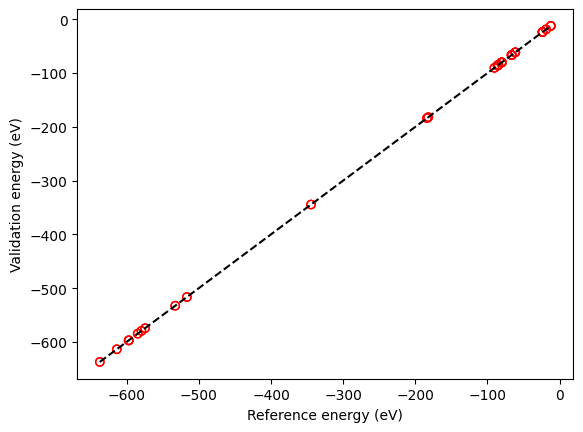

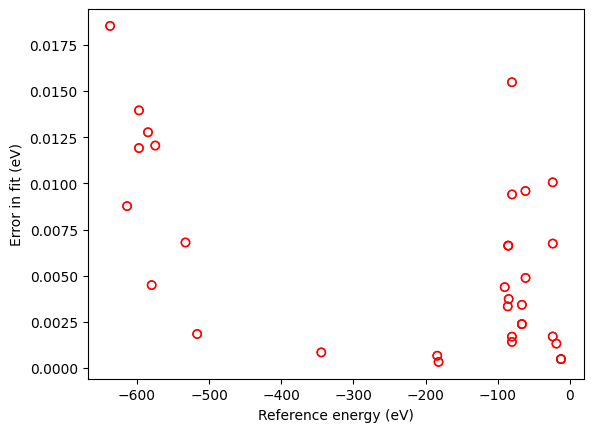

In [11]:
import numpy as np
import matplotlib.pyplot as plt

err=np.loadtxt("CCS_validate.dat")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


### Cleaning up

In [11]:
# import glob

# def rm(file):
#     try:
#         os.remove(file)
#     except OSError:
#         pass


# list=glob.glob("CALCULATED_DATA/*")
# for file in list:
#     rm(file)
# list=glob.glob("CCS_*")
# for file in list:
#     rm(file)
# list=glob.glob("UNC_*")
# for file in list:
#     rm(file)
# rm("structures.json")
# rm("file_list")
# rm("LJ.db")

### Convex hull

In [3]:
struct_no_Li = io.read('DFT.db@21')
struct_full_Li = io.read('DFT.db@10')

nrg_0 = struct_no_Li.get_potential_energy()
nrg_1 = struct_full_Li.get_potential_energy()

print(struct_no_Li.get_chemical_formula())
print(struct_full_Li.get_chemical_formula())

Ni27O54
Li27Ni27O54


Text(0, 0.5, 'Energy')

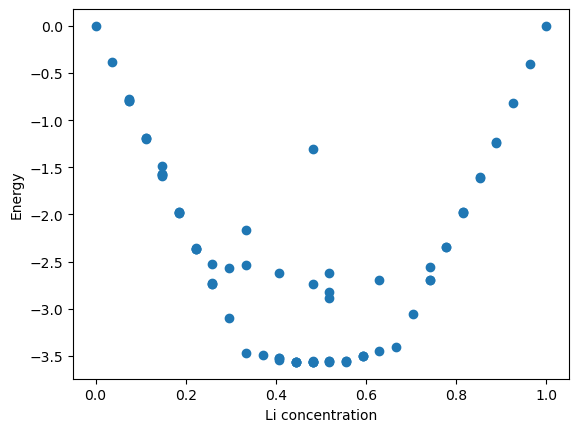

In [13]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db
import matplotlib.pyplot as plt

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
CCS_nrgs = []

i = 0

struct_no_Li_CCS = struct_no_Li.copy()
struct_full_Li_CCS = struct_full_Li.copy()

struct_no_Li_CCS.calc = CCS_calc
struct_full_Li_CCS.calc = CCS_calc

ECCS_no_Li = struct_no_Li_CCS.get_potential_energy()
ECCS_full_Li = struct_full_Li_CCS.get_potential_energy()

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(structure.get_magnetic_moments())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy()
    structure.calc = CCS_calc
    ECCS = structure.get_potential_energy() - (ECCS_no_Li) - (ECCS_full_Li-ECCS_no_Li)/27*nr_Li
    xs.append(x)
    CCS_nrgs.append(ECCS)
    i += 1

plt.scatter(xs, CCS_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

In [4]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
DFT_nrgs = []

i = 0

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(i)
    # print(dir(structure))
    # print(structure.get_magnetic_moment())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    print(i,x)
    EDFT = structure.get_potential_energy() - (nrg_0) - (nrg_1-nrg_0)/27*nr_Li
    xs.append(x)
    DFT_nrgs.append(EDFT)
    i += 1

plt.scatter(xs, DFT_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

0 0.48148148148148145
1 0.6296296296296297
2 0.7407407407407407
3 0.14814814814814814
4 0.25925925925925924
5 0.6666666666666666
6 0.7407407407407407
7 0.5925925925925926
8 0.5555555555555556
9 0.2962962962962963
10 1.0
11 0.37037037037037035
12 0.6296296296296297
13 0.14814814814814814
14 0.037037037037037035
15 0.8888888888888888
16 0.18518518518518517
17 0.8518518518518519
18 0.2222222222222222
19 0.7037037037037037
20 0.4444444444444444
21 0.0
22 0.07407407407407407
23 0.4074074074074074
24 0.18518518518518517
25 0.4444444444444444
26 0.25925925925925924
27 0.14814814814814814
28 0.8148148148148148
29 0.48148148148148145
30 0.3333333333333333
31 0.2962962962962963
32 0.5185185185185185
33 0.25925925925925924
34 0.8148148148148148
35 0.2222222222222222
36 0.07407407407407407
37 0.5925925925925926
38 0.5555555555555556
39 0.18518518518518517
40 0.4444444444444444
41 0.1111111111111111
42 0.14814814814814814
43 0.4074074074074074
44 0.48148148148148145
45 0.4074074074074074
46 0.51851

NameError: name 'plt' is not defined

In [6]:
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from ase import io

struct = io.read('DFT.db@11')

struct = struct # * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)

struct.rattle(0.05)
struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.001)

      Step     Time          Energy         fmax
BFGS:    0 10:48:52     -561.268213        0.1146
BFGS:    1 10:48:54     -561.269643        0.1122
BFGS:    2 10:48:56     -561.337006        0.0475
BFGS:    3 10:48:58     -561.340016        0.0643
BFGS:    4 10:49:01     -561.340464        0.0687
BFGS:    5 10:49:03     -561.341483        0.0736
BFGS:    6 10:49:05     -561.344638        0.0791
BFGS:    7 10:49:07     -561.350090        0.0722
BFGS:    8 10:49:09     -561.357177        0.0439
BFGS:    9 10:49:10     -561.362048        0.0239
BFGS:   10 10:49:12     -561.363869        0.0278
BFGS:   11 10:49:14     -561.364192        0.0303
BFGS:   12 10:49:15     -561.364356        0.0294
BFGS:   13 10:49:17     -561.365060        0.0261
BFGS:   14 10:49:19     -561.366362        0.0207
BFGS:   15 10:49:21     -561.369031        0.0135
BFGS:   16 10:49:23     -561.371671        0.0260
BFGS:   17 10:49:25     -561.373150        0.0294
BFGS:   18 10:49:28     -561.373529        0.0245
B

True

In [11]:
!ase gui opt.traj

In [2]:
# Read geometry optimized structure and run NVE Molecular dynamics 
import numpy as np
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)

dt = 0.5 * units.fs
steps = int(300)
MaxwellBoltzmannDistribution(struct, temperature_K=600)
dyn = VelocityVerlet(struct, timestep=dt)
interval = int(1)
dyn.attach(MDLogger(dyn, struct, 'output.log', mode="a"), interval=interval)
dyn.attach(Trajectory('output.traj', 'a', struct).write, interval=interval)
dyn.run(steps)

NameError: name 'struct' is not defined

In [19]:
!ase gui output.traj

Traceback (most recent call last):
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ase\gui\pipe.py", line 32, in <module>
    main()
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ase\gui\pipe.py", line 28, in main
    plt.show()
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\matplotlib\pyplot.py", line 421, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\matplotlib_inline\backend_inline.py", line 90, in show
    display(
  File "C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\IPython\core\display_functions.py", line 265, in display
    print(*objs)
ValueErro

In [50]:
## Stresses not currently implemented in ccs_fit yet!

from ase.constraints import StrainFilter

sf = StrainFilter(struct)
opt = BFGS(sf)
opt.run(0.005)

      Step     Time          Energy         fmax
BFGS:    0 12:20:11    -4056.685755        0.0000


True

In [18]:
structs = io.read('output.traj@:')

print(len(structs))

602


In [15]:
for i in range(2):
    print(structs[(i+1)*50])
    

Atom('O', [1.5302522558471303, 0.6498901747917316, 8.350791516660168], momentum=[0.0014744864791352498, -0.0003861502676627821, -0.0013253298584316594], index=40)
Atom('O', [4.184446643135762, 2.4776447376680752, 3.7608334497495246], momentum=[-0.0030845779832983197, 0.0027338945258879575, 0.0021347184935242842], index=80)


Buckingham fit (not optimised) for element pair O-O;     V(r) = 0.29*exp(-0.80*r) -(-9.48)/r^6.
Lennard Jones fit (not optimised) for element pair O-O;  V(r) = 4*1.19*((-0.01/r)^12 - (-0.01/r)^6)
Morse fit (not optimised) for element pair O-O;          V(r) = 0.00*(1-np.exp(-5.46*(r-0.01)))^2 + 0.02


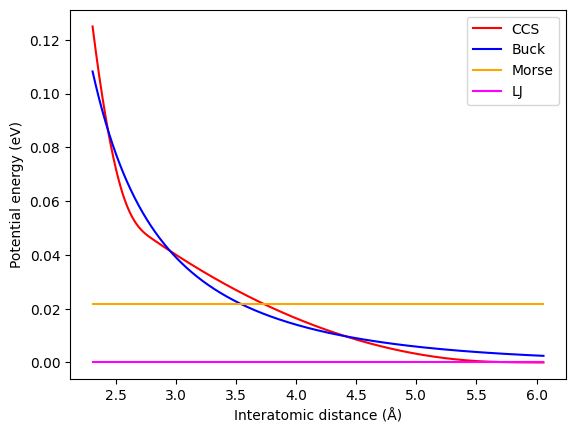

Buckingham fit (not optimised) for element pair Ni-Ni;     V(r) = 42.33*exp(-1.11*r) -(390.86)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Ni;  V(r) = 4*-1.20*((2.53/r)^12 - (2.53/r)^6)
Morse fit (not optimised) for element pair Ni-Ni;          V(r) = 1.14*(1-np.exp(-7.45*(r-0.00)))^2 + -0.74


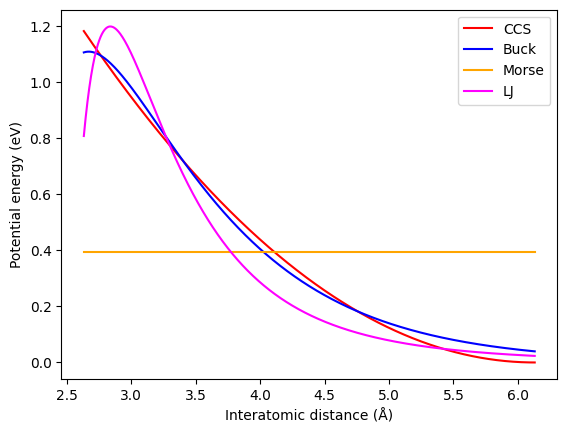

Buckingham fit (not optimised) for element pair Li-Li;     V(r) = 3.84*exp(-1.26*r) -(23.10)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Li;  V(r) = 4*-0.07*((2.41/r)^12 - (2.41/r)^6)
Morse fit (not optimised) for element pair Li-Li;          V(r) = 0.00*(1-np.exp(-3.98*(r-0.07)))^2 + 0.02


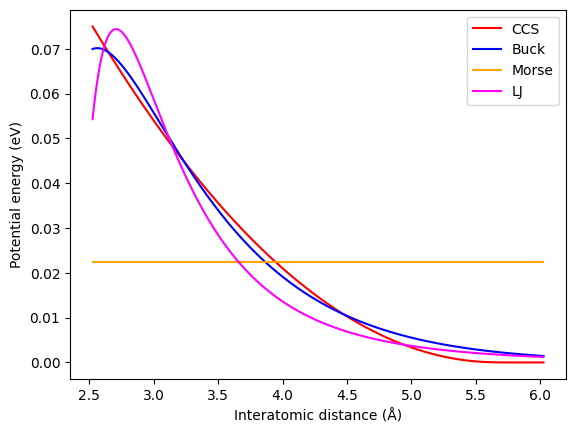

Buckingham fit (not optimised) for element pair Ni-Ta;     V(r) = 28750.49*exp(-1.28*r) -(170775.00)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Ta;  V(r) = 4*-497.32*((2.45/r)^12 - (2.45/r)^6)
Morse fit (not optimised) for element pair Ni-Ta;          V(r) = 115.32*(1-np.exp(-77.50*(r-0.02)))^2 + 32.92


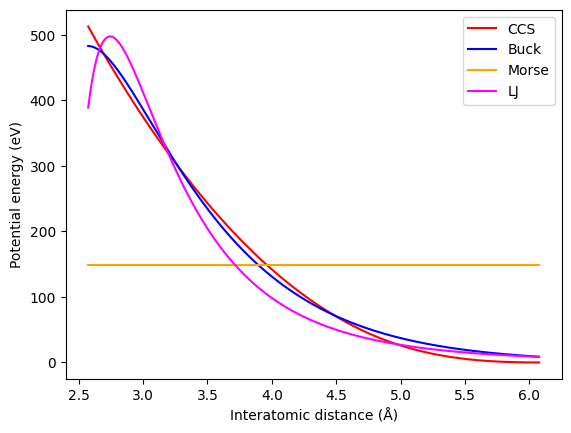

Buckingham fit (not optimised) for element pair Li-Ta;     V(r) = 58813.45*exp(-1.70*r) -(168750.21)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Ta;  V(r) = 4*-173.04*((2.36/r)^12 - (2.36/r)^6)
Morse fit (not optimised) for element pair Li-Ta;          V(r) = 21.77*(1-np.exp(-18.82*(r-0.08)))^2 + 20.61


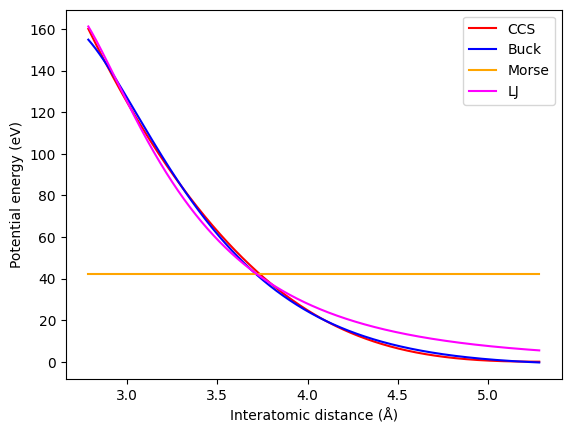

Buckingham fit (not optimised) for element pair Li-Ni;     V(r) = -33.55*exp(-1.17*r) -(-401.79)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Ni;  V(r) = 4*0.55*((2.53/r)^12 - (2.53/r)^6)
Morse fit (not optimised) for element pair Li-Ni;          V(r) = 0.50*(1-np.exp(-1.02*(r-2.98)))^2 + -0.44


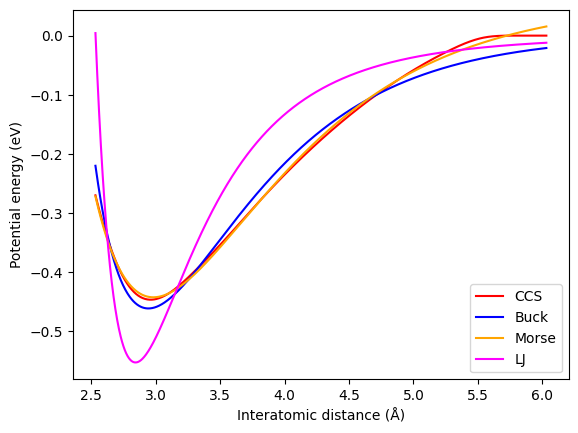

Buckingham fit (not optimised) for element pair Li-O;     V(r) = 2.89*exp(-0.83*r) -(6.01)/r^6.
Lennard Jones fit (not optimised) for element pair Li-O;  V(r) = 4*-0.60*((1.74/r)^12 - (1.74/r)^6)
Morse fit (not optimised) for element pair Li-O;          V(r) = 0.00*(1-np.exp(-7.30*(r-0.00)))^2 + 0.16


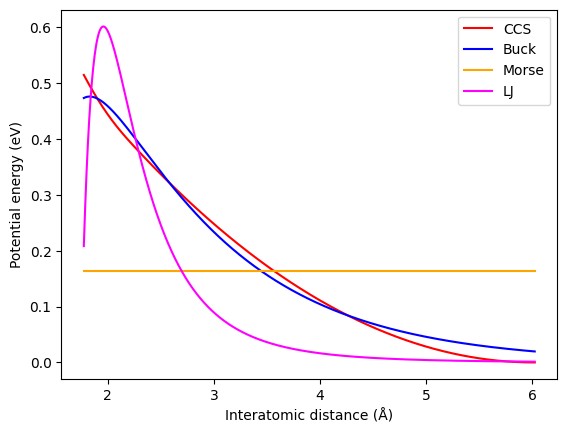

Buckingham fit (not optimised) for element pair Ni-O;     V(r) = -16.27*exp(-1.21*r) -(-28.67)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-O;  V(r) = 4*1.31*((1.59/r)^12 - (1.59/r)^6)
Morse fit (not optimised) for element pair Ni-O;          V(r) = 1.00*(1-np.exp(-1.34*(r-1.93)))^2 + -0.99


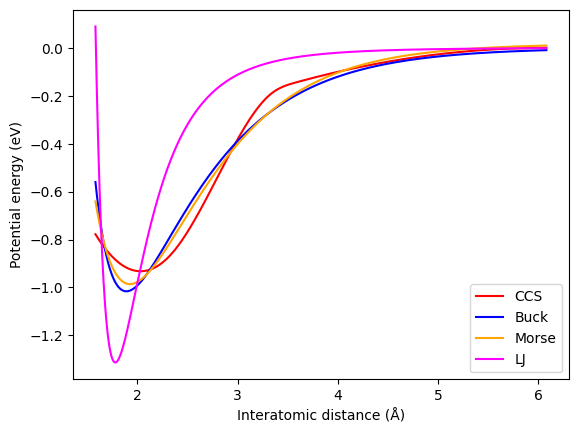

C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ccs_fit\scripts\ccs_export_FF.py:78: RuntimeWarning: overflow encountered in square
  return De*(1-np.exp(-a*(r-re)))**2 + C


Buckingham fit (not optimised) for element pair O-Ta;     V(r) = -152.75*exp(-66.52*r) -(43534.83)/r^6.
Lennard Jones fit (not optimised) for element pair O-Ta;  V(r) = 4*956.94*((1.72/r)^12 - (1.72/r)^6)
Morse fit (not optimised) for element pair O-Ta;          V(r) = 0.00*(1-np.exp(-17.05*(r-0.67)))^2 + -221.56


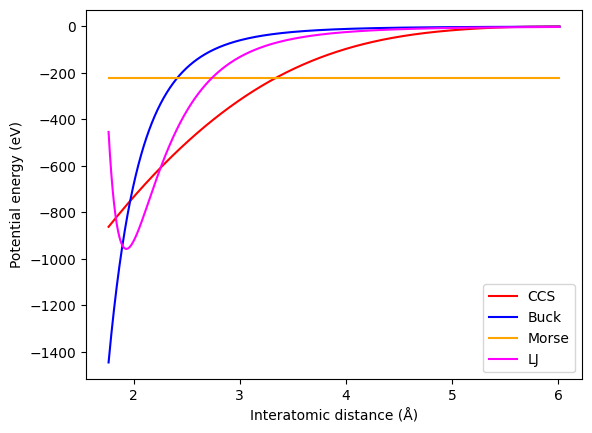

In [12]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")

In [8]:
import json
from ase import io
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)
CCS_calc = CCS(CCS_params=CCS_params)

phases = ["LNO_C2M","LNO_R3M","LNO_FD3M","LNO_P4332","LNO_P21C","LNO_P21C_2","NiO_FM3M","NiO_R3M","NiO2_P3M1"]

for phase in phases:
    struc = io.read(phase + ".POSCAR")
    struc.calc = CCS_calc
    nrg = struc.get_potential_energy()
    print(phase, nrg)

LNO_C2M -23.710095724642887
LNO_R3M -23.83662849130767
LNO_FD3M -86.06641163731372
LNO_P4332 -343.1729893508907
LNO_P21C -185.44559582131092
LNO_P21C_2 -187.93418818014698
NiO_FM3M -13.029929466891664
NiO_R3M -13.008453172915708
NiO2_P3M1 -18.141823660237236


In [19]:
import json
import numpy as np
from ase import io
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)
CCS_calc = CCS(CCS_params=CCS_params)

phases = ["LNO_R3M","LNO_C2M","LNO_P21C","LNO_P21C_2","NiO_FM3M","NiO2_P3M1","NiO_R3M","LNO_P4332","LNO_FD3M"]
numbers = np.arange(84,93,1)

for id, number in enumerate(numbers):
    outc = io.read("OUTCARS/" + str(number) + ".OUTCAR")
    DFT_nrg = outc.get_potential_energy()
    outc.calc = CCS_calc
    CCS_nrg = outc.get_potential_energy()
    print(outc.get_chemical_formula(), DFT_nrg, CCS_nrg)

LiNiO2 -16.36347227 -23.854921186991803
LiNiO2 -17.03068444 -23.851702483278345
Li8Ni8O16 -181.781323 -191.24699306335788
Li8Ni8O16 -185.82199344 -191.37553366016442
NiO -4.3271124 -18.73600107114562
NiO2 -11.69577073 -18.73009852954425
NiO -4.31351077 -18.737202782678388
Li8Ni16O32 -342.92916587 -342.91679293348034
Li2Ni4O8 -86.21031145 -85.71356124218923


In [3]:
import ase

!ccs_validate -d DFT.db -f True
!ase db CCS_validate.db


  0%|          | 0/319 [00:00<?, ?it/s]C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)

100%|##########| 319/319 [06:30<00:00,  1.22s/it]


id|age|formula    |calculator|natoms|pbc| volume|charge|    mass
 1| 7m|Li13Ni27O54|ccs       |    94|TTT|868.408| 0.000|2538.888
 2| 7m|Li13Ni27O54|ccs       |    94|TTT|866.202| 0.000|2538.888
 3| 7m|Li13Ni27O54|ccs       |    94|TTT|866.297| 0.000|2538.888
 4| 7m|Li13Ni27O54|ccs       |    94|TTT|867.486| 0.000|2538.888
 5| 7m|Li17Ni27O54|ccs       |    98|TTT|884.767| 0.000|2566.648
 6| 7m|Li17Ni27O54|ccs       |    98|TTT|884.767| 0.000|2566.648
 7| 6m|Li20Ni27O54|ccs       |   101|TTT|888.860| 0.000|2587.468
 8| 6m|Li20Ni27O54|ccs       |   101|TTT|888.600| 0.000|2587.468
 9| 6m|Li4Ni27O54 |ccs       |    85|TTT|856.196| 0.000|2476.428
10| 6m|Li4Ni27O54 |ccs       |    85|TTT|855.812| 0.000|2476.428
11| 6m|Li7Ni27O54 |ccs       |    88|TTT|863.845| 0.000|2497.248
12| 6m|Li7Ni27O54 |ccs       |    88|TTT|863.496| 0.000|2497.248
13| 6m|Li18Ni27O54|ccs       |    99|TTT|884.190| 0.000|2573.588
14| 6m|Li18Ni27O54|ccs       |    99|TTT|884.190| 0.000|2573.588
15| 6m|Li20Ni27O54|ccs   

In [22]:
import json
import numpy as np
from ase import io
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)
CCS_calc = CCS(CCS_params=CCS_params)

phases = ["LNO_R3M","LNO_C2M","LNO_P21C","LNO_P21C_2","NiO_FM3M","NiO2_P3M1","NiO_R3M","LNO_P4332","LNO_FD3M"]
numbers = np.arange(1,20,1)

for id, number in enumerate(numbers):
    outc = io.read("OUTCARS/" + str(number) + ".OUTCAR")
    DFT_nrg = outc.get_potential_energy()
    outc.calc = CCS_calc
    CCS_nrg = outc.get_potential_energy()
    print(outc.get_chemical_formula(), DFT_nrg/27, CCS_nrg/27)

Li27Ni27O54 -23.857964786296296 -23.85951040627236
Ni27O54 -18.780644566666666 -18.78089998371522
Li14Ni27O54 -21.510078127037037 -21.518965349179766
Li11Ni27O54 -20.943147802592595 -20.947210220519505
Li14Ni27O54 -21.516635525925928 -21.52108272913493
Li9Ni27O54 -20.553089626296295 -20.554098868719983
Li13Ni27O54 -21.31767250777778 -21.32758174723061
Li9Ni27O54 -20.568052014814814 -20.56780204543524
Li14Ni27O54 -21.504511066666666 -21.511139711716343
Li13Ni27O54 -21.26322963296296 -21.274690348596636
Li17Ni27O54 -22.068681998888888 -22.078392329806235
Li20Ni27O54 -22.63611130074074 -22.637488673364174
Li4Ni27O54 -19.588587106666665 -19.588305700215393
Li7Ni27O54 -20.19296297074074 -20.191263427390954
Li18Ni27O54 -22.29568306259259 -22.29274317502734
Li20Ni27O54 -22.645626247777777 -22.642801852054752
Li16Ni27O54 -21.921697841851852 -21.920224097715177
Li15Ni27O54 -21.735867306296296 -21.734013109786694
Li8Ni27O54 -20.38388889333333 -20.380693516061545
